# Equilibrium Algorithm Implementation for Metrics selection

### Import packages

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import euclidean_distances
import warnings
import utils
warnings.filterwarnings('ignore')

### Hyperparameters for Eqilibrium Algorithm

1. `omega` (default=0.9):
   - Controls the balance between accuracy and feature count
   - Range is 0 to 1
   - Higher values (closer to 1) prioritize accuracy
   - Lower values put more emphasis on reducing the number of selected features

2. `pool_size` (default=4):
   - Size of the equilibrium pool in the EO algorithm
   - Represents the number of best solutions kept as reference points
   - Larger pool size increases exploration but may slow convergence
   - Smaller pool size focuses more on exploitation of good solutions

3. `max_iter` (default=50):
   - Maximum number of iterations for the algorithm
   - Higher values allow more time for convergence but increase computation time
   - Lower values might lead to premature convergence

4. `part_count` (default=10):
   - Number of particles (candidate solutions) in the population
   - More particles increase exploration but require more computation
   - Fewer particles might miss good solutions but converge faster

EO-Specific Parameters:
1. `a1` (set to 2):
   - Controls the exploration rate
   - Higher values increase the search space exploration
   - Affects the F term in position updates

2. `a2` (set to 1):
   - Controls the exploitation rate
   - Influences how the time variable affects the search process
   - Used in calculating the time decay

3. `GP` (set to 0.5):
   - Generation probability
   - Threshold for switching between exploration and exploitation phases

The Time Variable (t):
- Decreases exponentially as iterations progress
- Controls the transition from exploration to exploitation
- Early iterations focus on exploration (high t)
- Later iterations focus on exploitation (low t)

These parameters affect the algorithm in different ways:

1. Exploration vs. Exploitation:
   - High a1, pool_size, part_count → More exploration
   - Low a2, small pool_size → More exploitation

2. Convergence Speed:
   - Higher max_iter → Slower but more thorough
   - Lower omega → Faster convergence but might miss optimal solutions

3. Solution Quality:
   - Higher omega → Better accuracy but more features
   - Lower omega → Fewer features but potentially lower accuracy

### Metrics selector class containing the Equilibrium Optimizer algorithm 

In [64]:
class MetricSelector:
    def __init__(self, fitness_func, dimension, max_features = None, omega=0.8, pool_size=4, max_iter=50, part_count=10, min_features=1,tolerance=1e-4, patience=5):
        self.omega = omega          # Weight between accuracy and number of features
        self.pool_size = pool_size  # Size of equilibrium pool
        self.max_iter = max_iter    # Maximum iterations
        self.part_count = part_count # Number of particles(solutions) in population
        self.scaler = StandardScaler()
        self.fitness_func = fitness_func
        self.min_features = min_features
        self.dimension = dimension
        self.max_features = int(0.5 * dimension)  if max_features is None else max_features
        self.tolerance = tolerance   # Minimum fitness improvement to continue
        self.patience = patience     # Number of iterations to tolerate without improvement
        self.no_improvement_count = 0  # Counter for patience

        # EO parameters
        self.a1 = 2
        self.a2 = 1
        self.GP = 0.5

        # save fitness for each iteration
        self.fitness_list:list = []

        assert self.min_features > 0 ,"Minimun number of features must be > 0"
        assert self.max_features >= self.min_features and self.max_features <= self.dimension,f"Max number of features must be in range {min_features} - {dimension}"
        
    
    def calculate_time(self, iteration):
        """Calculate time variable t for EO algorithm"""
        return (1 - iteration / self.max_iter) ** (self.a2 * iteration / self.max_iter)
    
    def preprocess_data(self, df: pd.DataFrame):
        """Preprocess the metrics data"""
        scaled_data = self.scaler.fit_transform(df)
        return scaled_data, df.columns
    
    def calculate_metric_importance(self, feature_selection_counts, feature_names):
        """Calculate importance scores for metrics based on selection frequency"""
        total_runs = len(feature_selection_counts)
        importance_scores = {}
        
        for i, feature in enumerate(feature_names):
            # selection_count = sum(1 for selection in feature_selection_counts if selection[i] == 1)
            selection_count = sum(selection[i] for selection in feature_selection_counts)
            importance_scores[feature] = selection_count / total_runs
            
        return importance_scores
    
    def select_features(self, data):
        """Main feature selection process"""
        feature_selection_counts = []
        
        # Initialize population with random feature subsets
        population = self.initialize_population()
        
        # Run EO algorithm multiple times
        for i in range(self.max_iter):
            eqPool, population, stop_EO = self.run_EO(population, data, i)
            # Store the selected features from this run
            feature_selection_counts.append(eqPool[0])
            if(stop_EO):
                break
        return feature_selection_counts
    
    def initialize_population(self):
        """Initialize population with random feature subsets"""
        population = np.zeros((self.part_count, self.dimension))
        # max_features for each solution
        
        for i in range(self.part_count):
            num_features = np.random.randint(self.min_features, self.max_features + 1)
            selected_features = np.random.choice(self.dimension, num_features, replace=False)
            population[i, selected_features] = 1
            
        return population
    
    def run_EO(self, population, data, current_iteration):
        """Run one iteration of the EO algorithm with early stopping"""
        # Early stop triggered or not
        stop_EO = False
        eqPool = np.zeros((self.pool_size, data.shape[1]))
        fitness_pool = np.full(self.pool_size, float('inf'))
        
        current_fitness = np.array([self.calculate_fitness(p, data) for p in population])
        
        # Update equilibrium pool
        all_solutions = np.vstack((population, eqPool))
        all_fitness = np.concatenate((current_fitness, fitness_pool))
        
        sorted_indices = np.argsort(all_fitness)
        eqPool = all_solutions[sorted_indices[:self.pool_size]]
        fitness_pool = all_fitness[sorted_indices[:self.pool_size]]
        
        # Calculate time
        t = self.calculate_time(current_iteration)
        new_population = np.zeros_like(population)
        
        # Update each particle
        for i in range(self.part_count):
            eq_idx = np.random.randint(0, self.pool_size)
            eq_candidate = eqPool[eq_idx]
            
            r1 = np.random.rand()
            r2 = np.random.rand()
            r3 = np.random.rand(data.shape[1])
            
            F = self.a1 * np.sign(r1 - 0.5) * (1 - np.exp(-2 * t))
            if r2 < 0.5:
                new_position = eq_candidate + F * (r3 * (eqPool[0] - population[i]))
            else:
                lambda_val = (1 - r2) * r3
                new_position = eq_candidate + F * (lambda_val * (eq_candidate - population[i]))
            
            prob = 1 / (1 + np.exp(-new_position))
            new_position = (prob > 0.5).astype(int)
            
            if np.sum(new_position) == 0:
                random_feature = np.random.randint(0, len(new_position))
                new_position[random_feature] = 1
            
            new_fitness = self.calculate_fitness(new_position, data)
            if new_fitness < current_fitness[i]:
                new_population[i] = new_position
            else:
                new_population[i] = population[i]
        
        best_fitness = min(fitness_pool[0], min(current_fitness))
        self.fitness_list.append(best_fitness)
        
        # Early Stopping Logic
        if len(self.fitness_list) > 1:
            improvement = abs(self.fitness_list[-2] - best_fitness)
            if improvement < self.tolerance:
                self.no_improvement_count += 1
            else:
                self.no_improvement_count = 0
            
            if self.no_improvement_count >= self.patience:
                stop_EO = True
                print(f"Early stopping triggered at iteration {current_iteration} with fitness: {best_fitness:.4f}")

        print(f'Iteration {current_iteration}, Best {self.fitness_func.__name__} fitness: {best_fitness:.4f}')
        return eqPool, new_population, stop_EO

    
    def calculate_fitness(self, particle, data):
        """Calculate fitness using fitness func"""
        if sum(particle) == 0:
            return float('inf')
            
        selected_features = data[:, particle == 1]
        error = self.fitness_func(data, selected_features)
            
        # Add penalty for number of features (normalized)
        feature_penalty = (sum(particle) / len(particle)) * (1 - self.omega)
        
        return error + feature_penalty
    
    def analyze_metrics(self, df):
        """Main method to analyze and select metrics"""
        scaled_data, feature_names = self.preprocess_data(df)
        feature_selections = self.select_features(scaled_data)
        '''Number of times selected/total number of iteration runs'''
        importance_scores = self.calculate_metric_importance(feature_selections, feature_names)
        return importance_scores


### Run the code

Score for each metric is determined by Number of times selected/total number of iteration runs

In [65]:
from collections import defaultdict

df = pd.read_csv("data/data_all.csv", index_col=0)
"""
result sample
{
sammons_error:[(0,1,2),(3,4,5)]
kruskal:[(0,1,2),(3,4,5)]
}
list of tuple containing (min,max,mean) for each iteration 
"""
#
fitness_result  = defaultdict(list)
importance_scores_result  = defaultdict(dict)
range_ = range(2, df.shape[1], 2)

# Run analysis with both fitness types
for fitness in [utils.calculate_sammon_error, utils.calculate_kruskal_stress]:
    for max_feats in range_:
        print(f"\nUsing {fitness.__name__} and Max features = {max_feats}")
        selector = MetricSelector(
            omega=0.9,
            pool_size=4,
            max_iter=50,
            part_count=10,
            dimension=df.shape[1],
            fitness_func=fitness,
            max_features=max_feats
        )
        results = selector.analyze_metrics(df)
        results = dict(sorted(results.items(), key=lambda x: x[1], reverse=True))
        fitness_result[fitness.__name__].append((np.min(selector.fitness_list), np.max(selector.fitness_list), np.mean(selector.fitness_list)))
        importance_scores_result[fitness.__name__] = results
        
        # Print results
        print("\nMetric Importance Scores:")
        print("-" * 40)
        print(f"{'Metric':<30} Score")
        print("-" * 40)
        for metric, score in results.items():
            print(f"{metric:<30} {score:.3f}")


Using calculate_sammon_error and Max features = 2
Iteration 0, Best calculate_sammon_error fitness: 0.6480
Iteration 1, Best calculate_sammon_error fitness: 0.5097
Iteration 2, Best calculate_sammon_error fitness: 0.4601
Iteration 3, Best calculate_sammon_error fitness: 0.3519
Iteration 4, Best calculate_sammon_error fitness: 0.3519
Iteration 5, Best calculate_sammon_error fitness: 0.3519
Iteration 6, Best calculate_sammon_error fitness: 0.3519
Iteration 7, Best calculate_sammon_error fitness: 0.3519
Early stopping triggered at iteration 8 with fitness: 0.3519
Iteration 8, Best calculate_sammon_error fitness: 0.3519

Metric Importance Scores:
----------------------------------------
Metric                         Score
----------------------------------------
NLM                            1.000
LLOC_y                         1.000
RFC                            0.778
CLOC_y                         0.778
TNOS_y                         0.778
HDIF                           0.778
HPL    

### Plot Error by Number of metrics 

In [66]:
import matplotlib.pyplot as plt

def plot_results(ax, k, min_vals, max_vals, mean_vals, algorithm_name):
    ax.plot(k, mean_vals, label='Mean Error', color='blue', marker='o', markersize=3, linewidth=1)
    ax.fill_between(k, min_vals, max_vals, color='gray', alpha=0.3, label='Max - Min error range')
    ax.set_title(f'{algorithm_name} Error Analysis')
    ax.set_xlabel('Number of Metrics')
    ax.set_ylabel(f'{algorithm_name} Error')
    ax.legend()
    ax.grid(True)

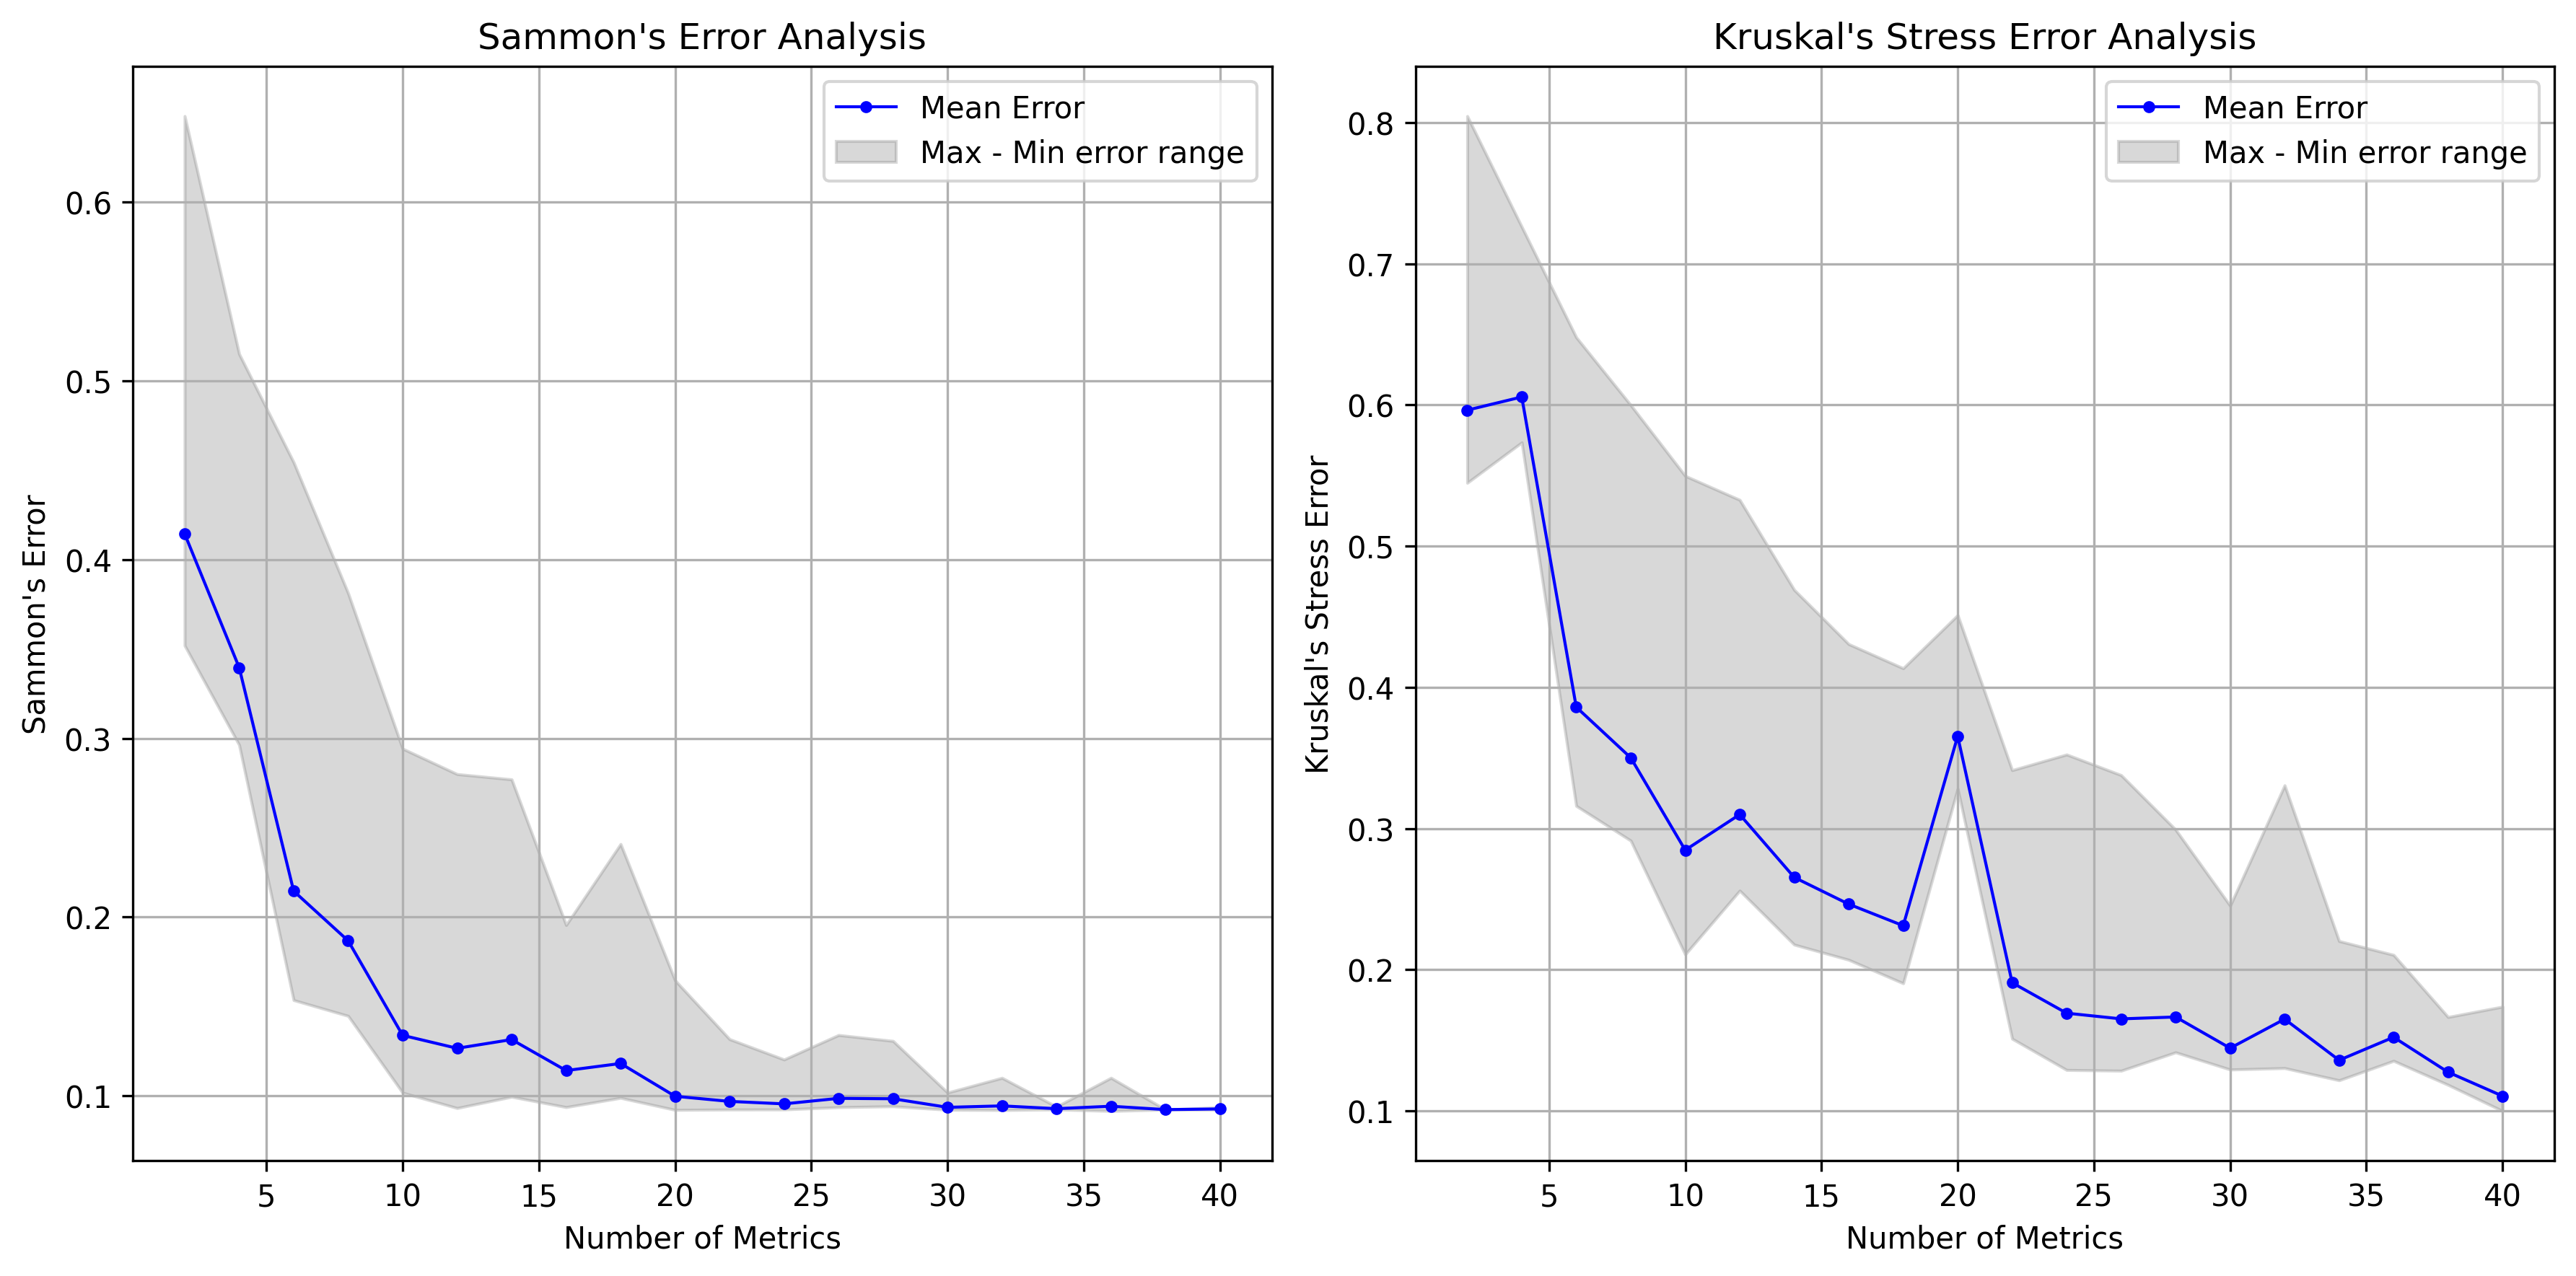

In [67]:
sammons_errors = list(zip(*fitness_result['calculate_sammon_error']))
kruskal_errors = list(zip(*fitness_result['calculate_kruskal_stress']))

fig, axs = plt.subplots(1, 2, figsize=(12, 6), dpi=300)  # 1 row, 2 columns

# Plot Sammon's error
plot_results(axs[0], range_, sammons_errors[0], sammons_errors[1], sammons_errors[2], "Sammon's")

# Plot Kruskal's stress
plot_results(axs[1], range_, kruskal_errors[0], kruskal_errors[1], kruskal_errors[2], "Kruskal's Stress")

# Adjust layout
plt.tight_layout()
plt.show()

### Plot selected metric by importance

We plot metrics that were most frequently selected (High importance score) by computing Number of times selected/total number of iteration runs

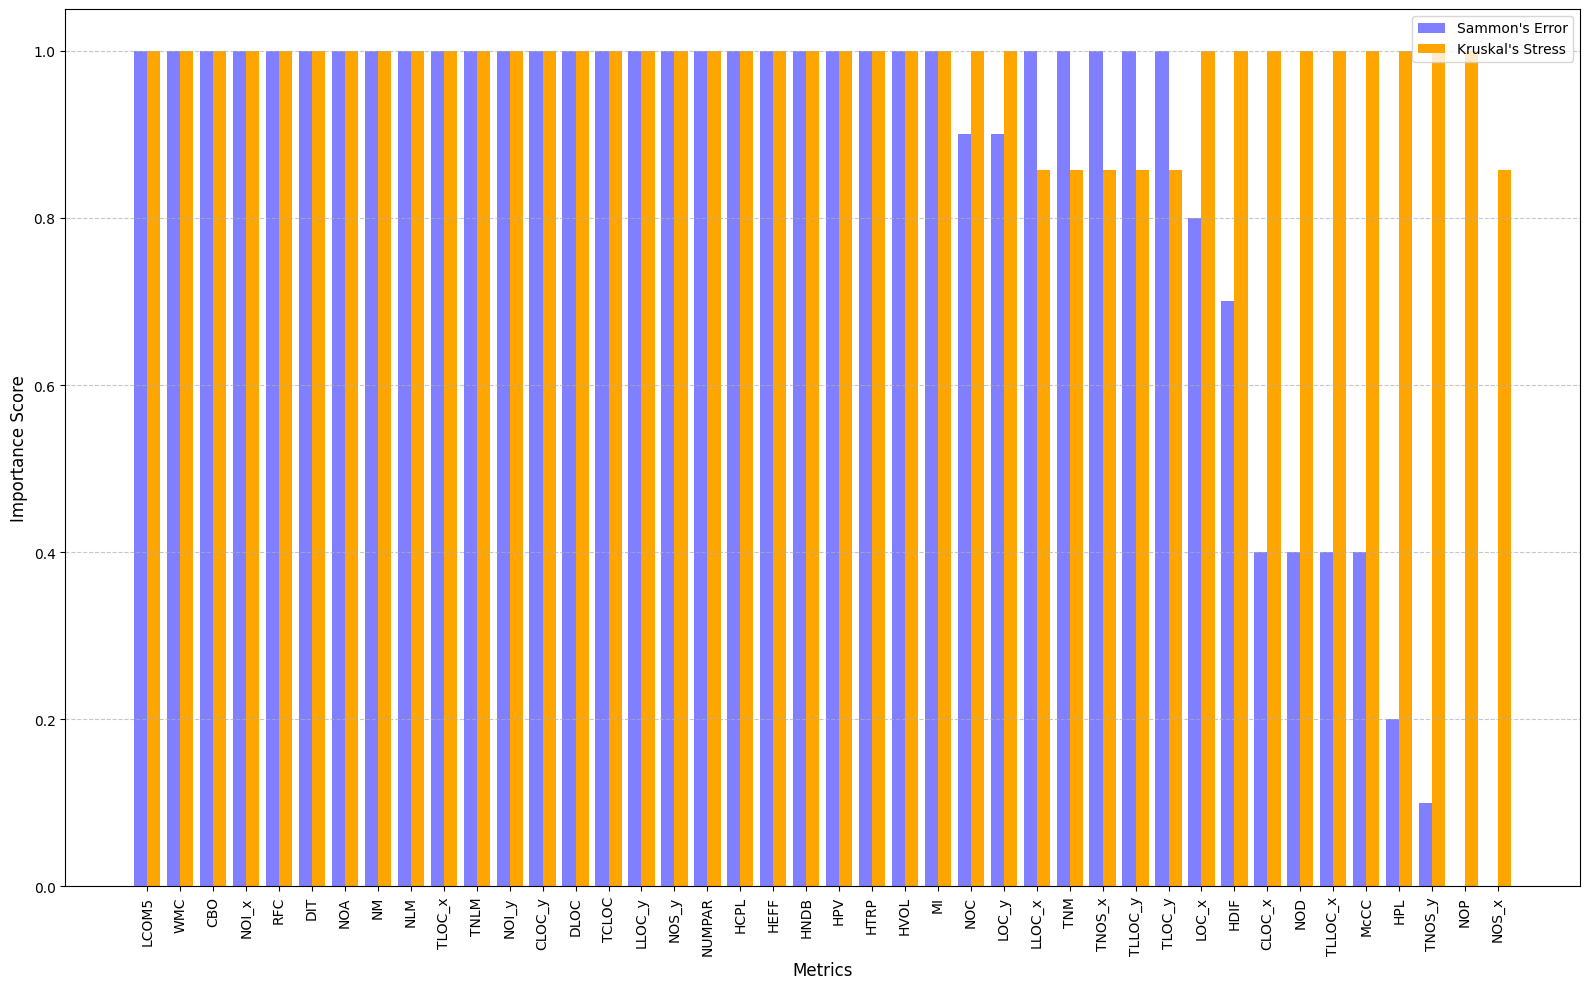

In [68]:
kruskal_scores = importance_scores_result['calculate_kruskal_stress']
sammons_scores = importance_scores_result['calculate_sammon_error']

# Combine scores for sorting
combined_scores = {
    metric: (sammons_scores[metric] + kruskal_scores[metric]) / 2
    for metric in sammons_scores.keys()
}

# Sort metrics by combined scores in descending order
sorted_metrics = sorted(combined_scores.keys(), key=lambda m: combined_scores[m], reverse=True)

# Extract sorted scores
sorted_simmons = [sammons_scores[metric] for metric in sorted_metrics]
sorted_kruskal = [kruskal_scores[metric] for metric in sorted_metrics]

# X-axis positions
x = np.arange(len(sorted_metrics))

# Bar width
bar_width = 0.4

plt.figure(figsize=(16, 10))
plt.bar(x - bar_width / 2, sorted_simmons, width=bar_width, color='blue',alpha=0.5, label="Sammon's Error")
plt.bar(x + bar_width / 2, sorted_kruskal, width=bar_width, color='orange', label="Kruskal's Stress")

# Add labels and titles
plt.xlabel('Metrics', fontsize=12)
plt.ylabel('Importance Score', fontsize=12)
plt.xticks(x, sorted_metrics, rotation=90, fontsize=10)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

## Conclusion

Most Important metrics can be gotten by choosing the first n metrics from the bar chart
From running the experiment multiple times, it can be noticed that the following metrics appeared to be chosen most often

**LOCM5, WMC, CBO, CLOC_x, LOC_x, DIT, NM**


**Effect of scaling**

When run without scaling, it is noticed that metrics with larger values such as **TLOC** and its subsets **(LOC, CLOC,TLLOC)** were frequently chosen as important metrics.


The hyperparameters play a huge role in reducing the error, noted examples include

- Initilaizing with high particle count(part_count) gives lower errors even with first few iterations.


**Possible impovements**

- Implement grid search for better hyper-parameter tuning
- Try different scalers in the data pre processing step
- Add other pre-processing steps like outlier detection